1 5
1 5
1 5
1 2
1 4


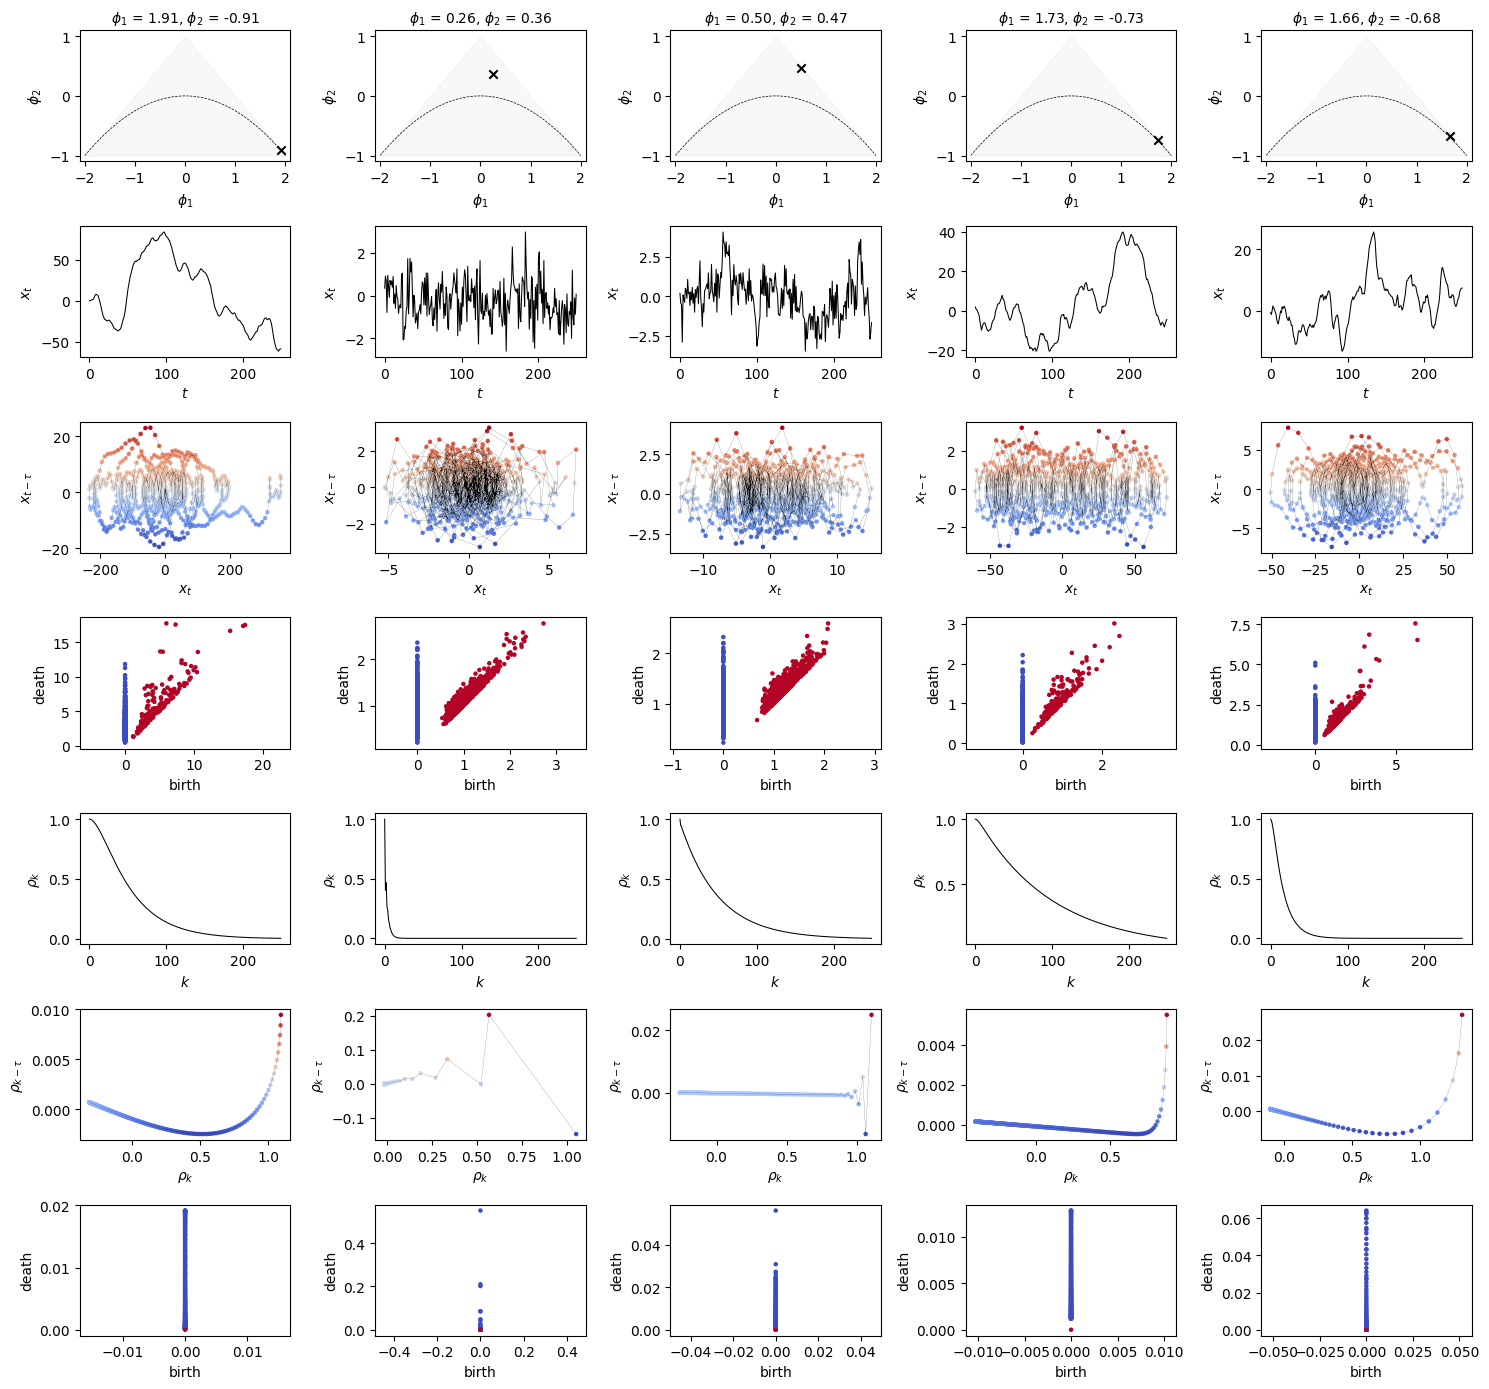

In [3]:
import matplotlib.pyplot as plt
import nb_utils
from gtda.homology import VietorisRipsPersistence
from gtda.time_series import SingleTakensEmbedding
from sklearn.decomposition import PCA
from src import acf_utils, plts, sim

plt.rcParams["image.cmap"] = "coolwarm"


emb = SingleTakensEmbedding(parameters_type="search", n_jobs=-1)
vr = VietorisRipsPersistence(
    metric="euclidean", max_edge_length=100, homology_dimensions=(0, 1), n_jobs=-1
)
pca = PCA(n_components=2)

n_sims, n_timepoints, n_lags = 5, 1000, 250

fig, axs = plt.subplots(nrows=7, ncols=n_sims, figsize=(15, 14))
plot_kwargs = dict(ls="-", lw=0.75)
scatter_kwargs = dict(s=5)

for idx in range(n_sims):
    phis = nb_utils.gen_ar2_coeffs(oscillatory=False, random_seed=idx + 10)

    X = sim.sim_ar(phis, n_timepoints, random_seed=idx).squeeze()
    # X = (X - X.mean(axis=0)) / X.std(axis=0)
    X_emb = emb.fit_transform(X)
    X_vr = vr.fit_transform(X_emb[None, ...])
    X_emb_pc = pca.fit_transform(X_emb)

    X_acf = acf_utils.ar_to_acf(phis, n_lags=n_lags)
    X_acf_emb = emb.fit_transform(X_acf)
    X_acf_vr = vr.fit_transform(X_acf_emb[None, ...])
    X_acf_emb_pc = pca.fit_transform(X_acf_emb)

    # stationarity triangle
    axs[0, idx].set_title(rf"$\phi_1$ = {phis[0]:.2f}, $\phi_2$ = {phis[1]:.2f}", fontsize=10)
    plts.plot_stationarity_triangle(axs[0, idx], fill_alpha=0.05, annotate=False)
    axs[0, idx].scatter(phis[0], phis[1], c="k", marker="x")

    # x_t
    axs[1, idx].plot(X[:n_lags], c="k", **plot_kwargs)
    axs[1, idx].set_xlabel(r"$t$")
    axs[1, idx].set_ylabel(r"$x_t$")

    # x_t embedding
    axs[2, idx].plot(X_emb_pc[:, 0], X_emb_pc[:, 1], c="k", lw=0.1)
    axs[2, idx].scatter(X_emb_pc[:, 0], X_emb_pc[:, 1], c=X_emb_pc[:, 1], **scatter_kwargs)
    axs[2, idx].set_xlabel(r"$x_t$")
    axs[2, idx].set_ylabel(r"$x_{t-\tau}$")

    # x_t vietoris rips
    axs[3, idx].scatter(X_vr[:, :, 0], X_vr[:, :, 1], c=X_vr[:, :, 2], **scatter_kwargs)
    axs[3, idx].axis("equal")
    axs[3, idx].set_xlabel("birth")
    axs[3, idx].set_ylabel("death")

    # rho_t
    axs[4, idx].plot(X_acf, c="k", **plot_kwargs)
    axs[4, idx].set_xlabel(r"$k$")
    axs[4, idx].set_ylabel(r"$\rho_k$")

    # rho_t embedding
    axs[5, idx].plot(X_acf_emb_pc[:, 0], X_acf_emb_pc[:, 1], c="k", lw=0.1)
    axs[5, idx].scatter(
        X_acf_emb_pc[:, 0], X_acf_emb_pc[:, 1], c=X_acf_emb_pc[:, 1], **scatter_kwargs
    )
    axs[5, idx].set_xlabel(r"$\rho_k$")
    axs[5, idx].set_ylabel(r"$\rho_{k-\tau}$")

    # rho_t vietoris rips
    axs[6, idx].scatter(X_acf_vr[:, :, 0], X_acf_vr[:, :, 1], c=X_acf_vr[:, :, 2], **scatter_kwargs)
    axs[6, idx].axis("equal")
    axs[6, idx].set_xlabel("birth")
    axs[6, idx].set_ylabel("death")


fig.tight_layout()